## Importing Data and Libraries

In [94]:
import pandas as pd
import numpy as np
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

In [95]:
Train = pd.read_csv('dataTrain.csv')
Test = pd.read_csv('dataTest.csv')

stats = pd.read_csv('stats.csv')
stats.columns = ['var', 'mean', 'std']

X_train = Train.drop('output', axis=1)
y_train = Train['output']

X_test = Test.drop('output', axis=1)
y_test = Test['output']

maxs = X_train.max().tolist()
mins = X_train.min().tolist()

var_names = X_train.columns.to_list()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241, 12), (61, 12), (241,), (61,))

In [96]:
savecols = X_train.columns

In [97]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.array
y_test = y_test.array

## Building the model

### Clustering

In this section, we will try out different numbers of clusters in order to minimize the separation between clusters. 

#### Functions

In [98]:
def SeparationMetric(X_train, clust_centers, part_matrix):
    metric = 0
    for clust in range(clust_centers.shape[0]):
        for point in range(X_train.shape[0]):
            metric += part_matrix[point, clust] * distance.euclidean(X_train[point], clust_centers[clust])
    return metric

#def SeparationMetric(X_train, clust_centers, part_matrix):
#    silhouette_score(X_train, )
#    return metric

In [99]:
# Since pyfume's clustering algorithm was using the the target, I made some modifcations to their fcm
# code as seen below

def fcm(data, n_clusters, m=2, max_iter=1000, error=0.005):
        #data: 2d array, size (N, S). N is the number of instances; S is the number of variables
        #n_clusters: number of clusters
        #m: fuzzy clustering coefficient
        #max_it: maximum number of iterations, default=1000
        #error: stopping criterion, default=0.005
        #seed: seed for random initialization of u matrix
        
    n_instances = data.shape[0]
        
    #randomly initaliaze u
    np.random.seed(1231241421)
    u = np.random.rand(n_instances, n_clusters)
    u = np.fmax(u, np.finfo(np.float64).eps)
    ut = u.T
        
    for it in range(0,max_iter):
        #copy old u matrix
        u_old = ut.copy()
        u_old /= np.ones((n_clusters, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
        u_old = np.fmax(u_old, np.finfo(np.float64).eps)
        
        #elevate to m
        um = u_old ** m
        
        #calculate cluster centers
        centers = um.dot(data) / (np.ones((data.shape[1], 1)).dot(np.atleast_2d(um.sum(axis=1))).T)
        
        #calculate distances
        dist = cdist(centers, data, metric='euclidean')
        dist = np.fmax(dist, np.finfo(np.float64).eps)
        
        #calculate objective
        jm = (um * dist ** 2).sum()
    
        #calculate new u matrix
        ut = dist ** (- 2. / (m - 1))
        ut /= np.ones((n_clusters, 1)).dot(np.atleast_2d(ut.sum(axis=0)))
    
        #stopping criterion
        if np.linalg.norm(ut - u_old) < error:
            break
    
    partition_matrix = ut.T
    return centers, partition_matrix

In [100]:
def Cluster(nclusters):
    clust_centers, part_matrix = fcm(X_train, n_clusters = nclusters)
    return clust_centers, part_matrix

#### Code

In [101]:
max_clusters = 5
min_metric = np.inf

for i in range(max_clusters):
    i += 1
    clust_centers, part_matrix = Cluster(i)
    metric = SeparationMetric(X_train, clust_centers, part_matrix)
    if metric < min_metric:
        min_metric = metric
        best_number = i

print(f'Best number of clusters: {best_number}')

Best number of clusters: 5


In [102]:
clust_centers, part_matrix = Cluster(best_number)
clust_centers.shape, part_matrix.shape

((5, 12), (241, 5))

### Building the model

In [103]:
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
model = modbuilder.get_model()

 * Detected 5 rules / clusters
 * Detected Sugeno model type


### Inference and Metrics

In [104]:
modtester = SugenoFISTester(model, X_test, var_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

In [105]:
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.836
Recall: 0.844
Precision Score: 0.844
F1-Score: 0.844
Kappa Score: 0.671


## Model Visualization/Interpretation

In [106]:
model._lvs['chol'] # example of how pyFUME defines une linguistic variable in simpful

<Linguistic variable 'chol', contains fuzzy sets [<Fuzzy set (function), term='cluster1'>, <Fuzzy set (function), term='cluster2'>, <Fuzzy set (function), term='cluster3'>, <Fuzzy set (function), term='cluster4'>, <Fuzzy set (function), term='cluster5'>], universe of discourse: None>

In [107]:
model.get_rules() # print the rules associated with the model

['IF ((sex IS cluster1) AND ((cp IS cluster1) AND ((trtbps IS cluster1) AND ((chol IS cluster1) AND ((fbs IS cluster1) AND ((restecg IS cluster1) AND ((thalachh IS cluster1) AND ((exng IS cluster1) AND ((oldpeak IS cluster1) AND ((slp IS cluster1) AND ((caa IS cluster1) AND (thall IS cluster1)))))))))))) THEN (OUTPUT IS fun1)',
 'IF ((sex IS cluster2) AND ((cp IS cluster2) AND ((trtbps IS cluster2) AND ((chol IS cluster2) AND ((fbs IS cluster2) AND ((restecg IS cluster2) AND ((thalachh IS cluster2) AND ((exng IS cluster2) AND ((oldpeak IS cluster2) AND ((slp IS cluster2) AND ((caa IS cluster2) AND (thall IS cluster2)))))))))))) THEN (OUTPUT IS fun2)',
 'IF ((sex IS cluster3) AND ((cp IS cluster3) AND ((trtbps IS cluster3) AND ((chol IS cluster3) AND ((fbs IS cluster3) AND ((restecg IS cluster3) AND ((thalachh IS cluster3) AND ((exng IS cluster3) AND ((oldpeak IS cluster3) AND ((slp IS cluster3) AND ((caa IS cluster3) AND (thall IS cluster3)))))))))))) THEN (OUTPUT IS fun3)',
 'IF ((sex

In [108]:
# The pyFUME library doesn't atribute a universe of discourse to the linguistic variables it creates in simpful. In order to fix this, we set each universe considering the maximum
# value heald by each dataframe column. This has to be done since, otherwise, the plotting functions won't work.

for ix in range(len(var_names)):
    max = maxs[ix]
    min = mins[ix]
    uod = [min, max]
    model._lvs[var_names[ix]]._universe_of_discourse = uod


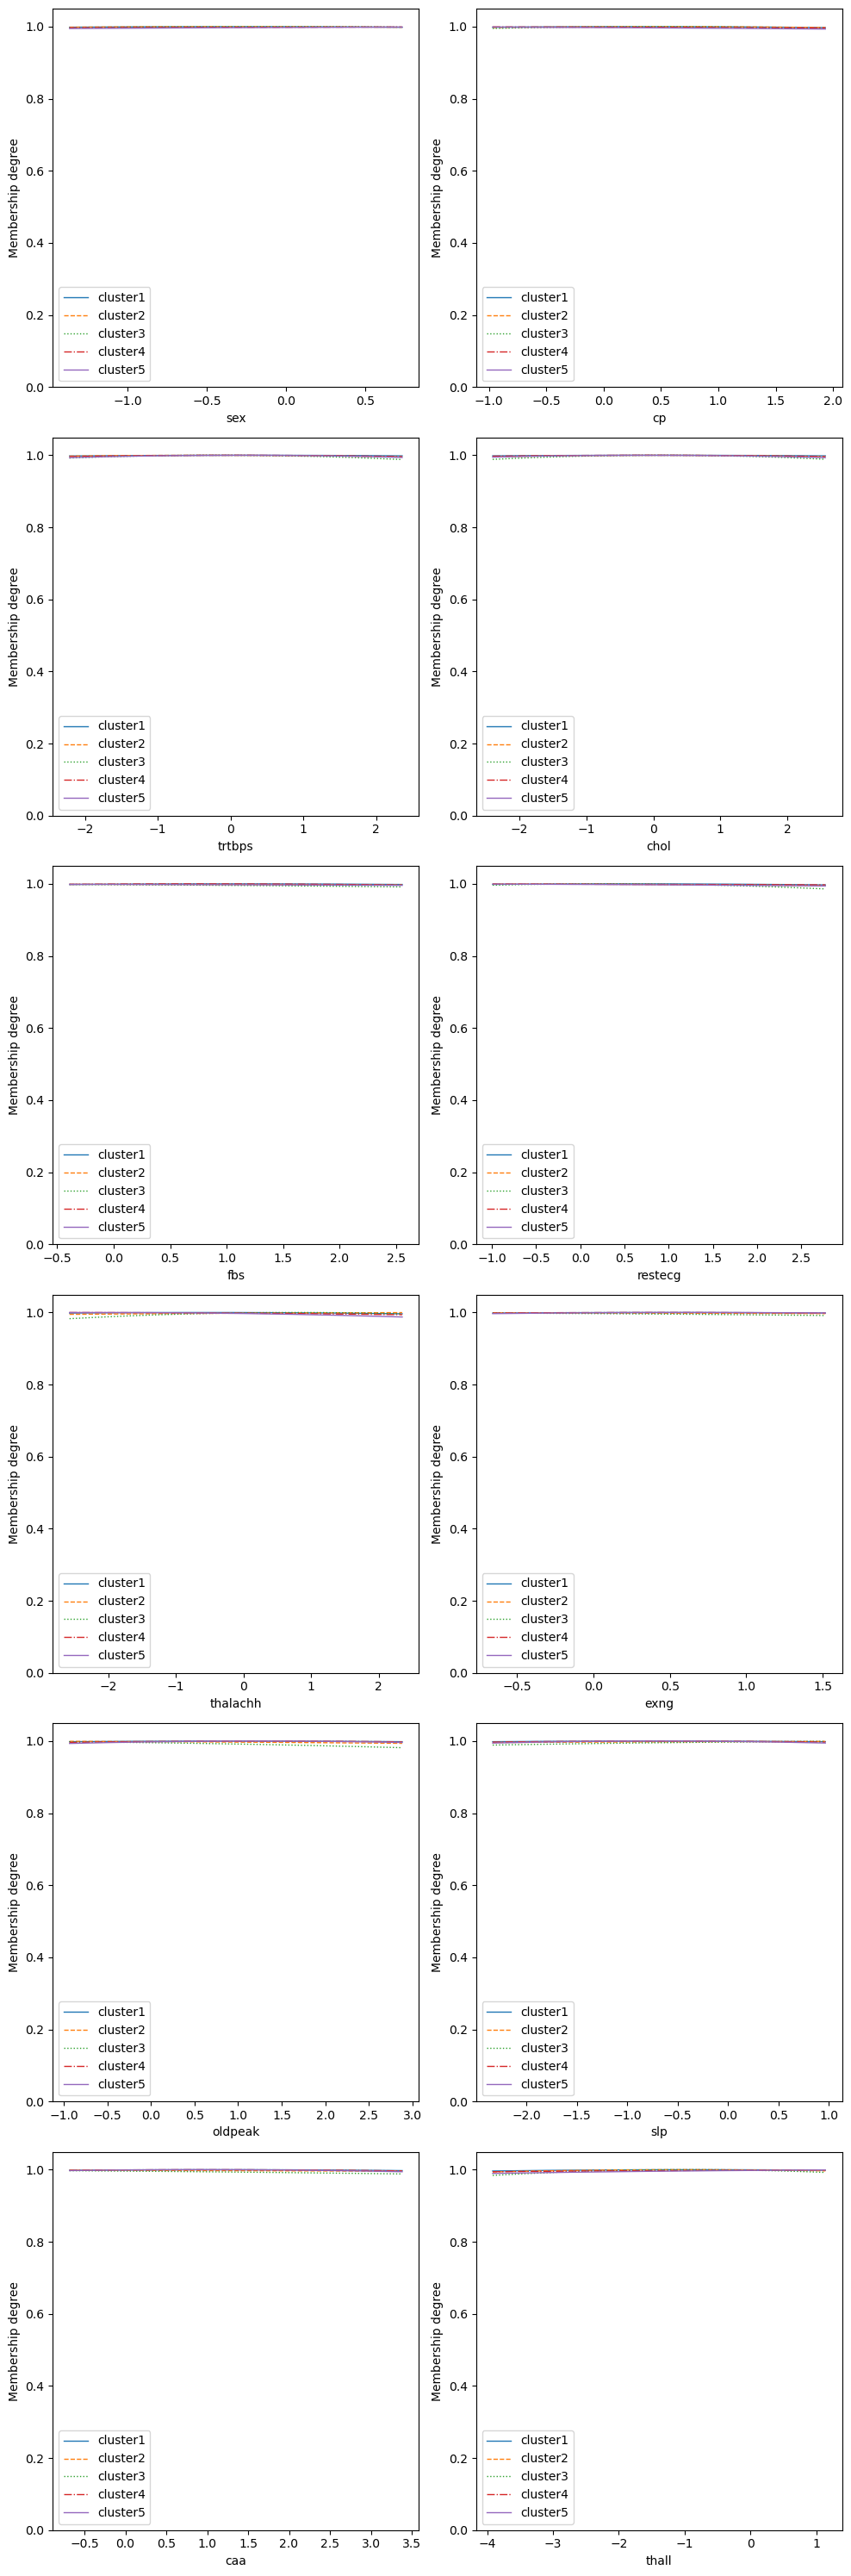

In [109]:
model.produce_figure("",2)

In [110]:
stats

,var,mean,std
0,age,54.373444,9.180230
1,sex,0.651452,0.477502
2,cp,1.000000,1.036822
3,trtbps,130.784232,16.645918
4,chol,245.033195,47.577294
5,fbs,0.132780,0.340043
6,restecg,0.526971,0.532583
7,thalachh,149.759336,22.312883
8,exng,0.302905,0.460471
9,oldpeak,0.978423,1.050690


In [201]:
def ModelToZ(model, stats):
    for f in model._outputfunctions:
        expression = model._outputfunctions[f]
        item_list = expression.split('+')
        for k in range(len(item_list) - 1):
            item_list[k] = item_list[k].split('*')
            values = stats[stats['var'] == item_list[k][1]]
            item_list[k][0] = float(item_list[k][0]) * values.iloc[0,2] + values.iloc[0,1]
        finalfunct = ''
        for sum in item_list:
            if len(sum) != 1: finalfunct = finalfunct + str(sum[0]) + '*' + sum[1] + '+'
        finalfunct = finalfunct[:-4] + str(item_list[-1])
        print(item_list)
        print(finalfunct)

In [202]:
ModelToZ(model, stats)

[[0.6035708977895086, 'sex'], [1.0906708570657555, 'cp'], [129.9628561908861, 'trtbps'], [243.82892188831914, 'chol'], [0.14183656016966834, 'fbs'], [0.5422890555587371, 'restecg'], [151.19286298070153, 'thalachh'], [0.2684416028900656, 'exng'], [0.9197193766561351, 'oldpeak'], [1.4563825734758125, 'slp'], [0.5655171371974941, 'caa'], [2.272413812462226, 'thall'], '5.477018e-01']
0.6035708977895086*sex+1.0906708570657555*cp+129.9628561908861*trtbps+243.82892188831914*chol+0.14183656016966834*fbs+0.5422890555587371*restecg+151.19286298070153*thalachh+0.2684416028900656*exng+0.9197193766561351*oldpeak+1.4563825734758125*slp+0.5655171371974941*caa+2.272413812462226*thall+5.477018e-01
[[0.6035874671139501, 'sex'], [1.0905240223245327, 'cp'], [129.96372194507754, 'trtbps'], [243.82787756671837, 'chol'], [0.14184718991754477, 'fbs'], [0.5423009055280799, 'restecg'], [151.19454470270753, 'thalachh'], [0.26842584098062633, 'exng'], [0.9198073719314406, 'oldpeak'], [1.4564026801604513, 'slp'], 

In [180]:
vars(model)

{'_rules': [[f.(c.(sex IS cluster1) AND f.(c.(cp IS cluster1) AND f.(c.(trtbps IS cluster1) AND f.(c.(chol IS cluster1) AND f.(c.(fbs IS cluster1) AND f.(c.(restecg IS cluster1) AND f.(c.(thalachh IS cluster1) AND f.(c.(exng IS cluster1) AND f.(c.(oldpeak IS cluster1) AND f.(c.(slp IS cluster1) AND f.(c.(caa IS cluster1) AND c.(thall IS cluster1)))))))))))),
   ('OUTPUT', 'fun1')],
  [f.(c.(sex IS cluster2) AND f.(c.(cp IS cluster2) AND f.(c.(trtbps IS cluster2) AND f.(c.(chol IS cluster2) AND f.(c.(fbs IS cluster2) AND f.(c.(restecg IS cluster2) AND f.(c.(thalachh IS cluster2) AND f.(c.(exng IS cluster2) AND f.(c.(oldpeak IS cluster2) AND f.(c.(slp IS cluster2) AND f.(c.(caa IS cluster2) AND c.(thall IS cluster2)))))))))))),
   ('OUTPUT', 'fun2')],
  [f.(c.(sex IS cluster3) AND f.(c.(cp IS cluster3) AND f.(c.(trtbps IS cluster3) AND f.(c.(chol IS cluster3) AND f.(c.(fbs IS cluster3) AND f.(c.(restecg IS cluster3) AND f.(c.(thalachh IS cluster3) AND f.(c.(exng IS cluster3) AND f.(c.(ol